# Import Libraries

In [39]:
import pandas as pd
import numpy as np

#Use Keras Neural Network Components. This will be used to construct the LSTM
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.layers import BatchNormalization
from keras.layers import LayerNormalization
from keras.layers import MultiHeadAttention
from keras.regularizers import L1L2
from keras.layers import Layer
from keras import Model
from keras.optimizers import Adam


#Import Tensorflow 
import tensorflow as tf

#Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Confusion Matrix Library
from sklearn.metrics import confusion_matrix

# Ensure Reproducability of Results

In [40]:
np.random.seed(42)
tf.random.set_seed(42)

# Fetch and Set Up Data

In [41]:
#Numerically Encode the Activities
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

In [42]:
DATDIR = "data/UCI HAR Dataset"
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
    ]

In [43]:
#train_test: 0 if we want to fetch the training signal data, 1 if we want to fetch the test signal data
def fetch_raw_signal_data(train_test, signal):
    file_path = DATDIR + f"/{'train' if train_test == 0 else 'test'}/Inertial Signals/{signal}_{'train' if train_test == 0 else 'test'}.txt"
    return pd.read_csv(file_path, delim_whitespace = True, header = None)

#Same purpose as previous function but, in this case, we are fetching ALL the raw signal data!
#train_test: 0 if we want to fetch the training signal data, 1 if we want to fetch the test signal data
def fetch_all_raw_signals(train_test):
    data_raw_signals = []
    for signal in SIGNALS:
        raw_signal_data = fetch_raw_signal_data(train_test, signal).to_numpy()
        data_raw_signals.append(raw_signal_data)
    
    data_raw_signals = np.array(data_raw_signals)
    return np.transpose(data_raw_signals, axes = (1, 2, 0))

#Fetch Labels
#train_test: 0 if we want to fetch the training signal data, 1 if we want to fetch the test signal data
def fetch_labels(train_test):
    file_path = DATDIR + f"/{'train' if train_test == 0 else 'test'}/y_{'train' if train_test == 0 else 'test'}.txt"
    return pd.get_dummies(pd.read_csv(file_path, delim_whitespace=True, header = None)[0]).to_numpy()

In [44]:
X_train, X_test, Y_train, Y_test = fetch_all_raw_signals(0), fetch_all_raw_signals(1), fetch_labels(0), fetch_labels(1)

N = X_train.shape[0]
T = X_train.shape[1]
D = X_train.shape[2]

print(N, T, D)

n_classes = Y_train.shape[1]
print(n_classes)
print(X_train.shape, Y_train.shape)

7352 128 9
6
(7352, 128, 9) (7352, 6)


# Define LSTM Architecture

## Architecture 1: 2 LSTM Layers With Attention Layer

In [45]:
##Hyperparameters
epochs = 30
batch_size = 128

n_hidden_1 = 64
n_hidden_2 = 32
n_hidden_3 = 16
n_hidden_4 = 8

dropout_p = 0.5
num_heads = 6

In [46]:
class AttentionBlock(Layer):
    def __init__(self, num_heads, key_dim, fc_dim):
        super().__init__()
        self.dropout = Dropout(0.1)
        self.attention = MultiHeadAttention(num_heads = num_heads, key_dim = key_dim, value_dim = key_dim)
        self.fc = Sequential([Dense(fc_dim, activation="relu")])
        
    def call(self, inputs, training):
        attention_output = self.attention(inputs, inputs)
        attention_output = self.dropout(attention_output, training = training)        
        fc_output = self.fc(attention_output)
        fc_output = self.dropout(fc_output, training = training)
        return fc_output


In [47]:
model = Sequential() #Initializing our Model Architecture

model.add(LSTM(n_hidden_1, input_shape = (T, D), return_sequences=True)) # Add an LSTM Layer
model.add(AttentionBlock(num_heads = num_heads, key_dim = n_hidden_1, fc_dim = n_hidden_2)) #Add a Multihead Attention Layer
model.add(BatchNormalization()) #Add Batch Normalization Layer

model.add(LSTM(n_hidden_3)) #Add another LSTM to come after the AttentionBlock
model.add(BatchNormalization()) #Add Batch Normalization Layer

model.add(Dense(n_hidden_4, activation = "relu")) #Add another Dense Layer
model.add(Dropout(dropout_p)) # Adding a dropout layer
model.add(Dense(n_classes, activation = 'softmax')) #Adding a Dense Layer with the Softmax Activation Function

model.summary() #Display a Summary of our model architecture

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 128, 64)           18944     
                                                                 
 attention_block_2 (Attenti  (None, 128, 32)           101600    
 onBlock)                                                        
                                                                 
 batch_normalization_6 (Bat  (None, 128, 32)           128       
 chNormalization)                                                
                                                                 
 lstm_8 (LSTM)               (None, 16)                3136      
                                                                 
 batch_normalization_7 (Bat  (None, 16)                64        
 chNormalization)                                                
                                                      

In [48]:
# Compiling the model
optimizer = Adam(learning_rate=1e-4, weight_decay=1e-4, epsilon = 1e-10)
model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [49]:
# Training the model
model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test),epochs=epochs)

Epoch 1/30
58/58 [==============================] - 107s 2s/step - loss: 1.7229 - accuracy: 0.2591 - val_loss: 1.7833 - val_accuracy: 0.4018
Epoch 2/30
58/58 [==============================] - 90s 2s/step - loss: 1.4551 - accuracy: 0.3804 - val_loss: 1.7717 - val_accuracy: 0.4951
Epoch 3/30
58/58 [==============================] - 89s 2s/step - loss: 1.3701 - accuracy: 0.4105 - val_loss: 1.7523 - val_accuracy: 0.5168
Epoch 4/30
58/58 [==============================] - 89s 2s/step - loss: 1.3260 - accuracy: 0.4331 - val_loss: 1.7167 - val_accuracy: 0.5470
Epoch 5/30
58/58 [==============================] - 86s 1s/step - loss: 1.2908 - accuracy: 0.4509 - val_loss: 1.6626 - val_accuracy: 0.6047
Epoch 6/30
58/58 [==============================] - 107s 2s/step - loss: 1.2571 - accuracy: 0.4714 - val_loss: 1.5939 - val_accuracy: 0.6186
Epoch 7/30
58/58 [==============================] - 88s 2s/step - loss: 1.1967 - accuracy: 0.5143 - val_loss: 1.4704 - val_accuracy: 0.6888
Epoch 8/30
58/58 [

In [50]:
#Generate Confusion Matrix
Y_test_labels = np.argmax(Y_test, axis=1)
Y_prediction_labels = np.argmax(model.predict(X_test), axis = 1)
normalized_cm = confusion_matrix(Y_test_labels, Y_prediction_labels, normalize = 'true')

93/93 [==============================] - 15s 131ms/step


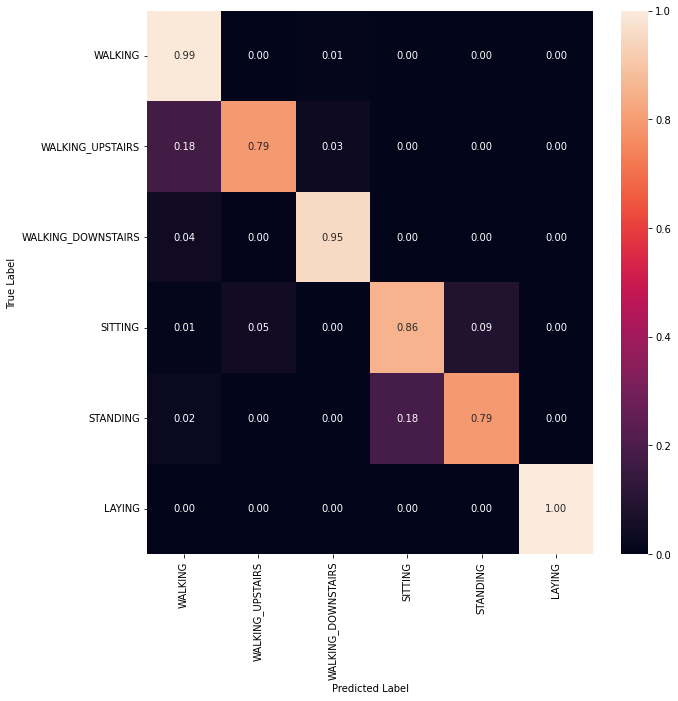

In [51]:
#List out target names
target_names = list(ACTIVITIES.values())

#Use seaborn to plot heat map of confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(normalized_cm, annot=True, fmt='.2f', xticklabels = target_names, yticklabels = target_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show(block=False)

In [52]:
score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 [==============================] - 12s 124ms/step - loss: 0.4729 - accuracy: 0.8962

   cat_crossentropy  ||   accuracy 
  ____________________________________
[0.4728853404521942, 0.8961656093597412]


## Architecture 2: Use 2 LSTM Layers

In [53]:
##Hyperparameters
epochs = 30
batch_size = 16
n_hidden_1 = 64
dropout_p = 0.5
n_hidden_2 = 32
n_hidden_3 = 16

In [54]:
model = Sequential() #Initializing our Model Architecture

#Define LSTM Layer with Batch Normalization
model.add(LSTM(n_hidden_1, input_shape=(T, D), return_sequences=True))
model.add(BatchNormalization())

#Define Dropout Layer
model.add(Dropout(dropout_p))

#Define the second LSTM Layer with Batch Normalization
model.add(LSTM(n_hidden_2))
model.add(BatchNormalization())

#Define Dropout Layer
model.add(Dropout(dropout_p))

#Define Dense Layer
model.add(Dense(n_hidden_3, activation = 'relu'))

#Define Dense Layer
model.add(Dense(n_classes, activation = 'softmax'))

#Print Model Summary
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 128, 64)           18944     
                                                                 
 batch_normalization_8 (Bat  (None, 128, 64)           256       
 chNormalization)                                                
                                                                 
 dropout_9 (Dropout)         (None, 128, 64)           0         
                                                                 
 lstm_10 (LSTM)              (None, 32)                12416     
                                                                 
 batch_normalization_9 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 32)               

In [55]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [56]:
# Training the model
model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test),epochs=epochs)

Epoch 1/30
460/460 [==============================] - 63s 117ms/step - loss: 0.9437 - accuracy: 0.6196 - val_loss: 0.9331 - val_accuracy: 0.6295
Epoch 2/30
460/460 [==============================] - 51s 112ms/step - loss: 0.6102 - accuracy: 0.7511 - val_loss: 0.7035 - val_accuracy: 0.7441
Epoch 3/30
460/460 [==============================] - 52s 113ms/step - loss: 0.3784 - accuracy: 0.8716 - val_loss: 0.4337 - val_accuracy: 0.8490
Epoch 4/30
460/460 [==============================] - 59s 128ms/step - loss: 0.2792 - accuracy: 0.9041 - val_loss: 0.2249 - val_accuracy: 0.9084
Epoch 5/30
460/460 [==============================] - 57s 123ms/step - loss: 0.2337 - accuracy: 0.9217 - val_loss: 0.2525 - val_accuracy: 0.8911
Epoch 6/30
460/460 [==============================] - 56s 122ms/step - loss: 0.2112 - accuracy: 0.9241 - val_loss: 0.2917 - val_accuracy: 0.9077
Epoch 7/30
460/460 [==============================] - 57s 123ms/step - loss: 0.1891 - accuracy: 0.9316 - val_loss: 0.4477 - val_ac

In [57]:
#Generate Confusion Matrix
Y_test_labels = np.argmax(Y_test, axis=1)
Y_prediction_labels = np.argmax(model.predict(X_test), axis = 1)
normalized_cm = confusion_matrix(Y_test_labels,Y_prediction_labels, normalize = 'true')

93/93 [==============================] - 10s 80ms/step


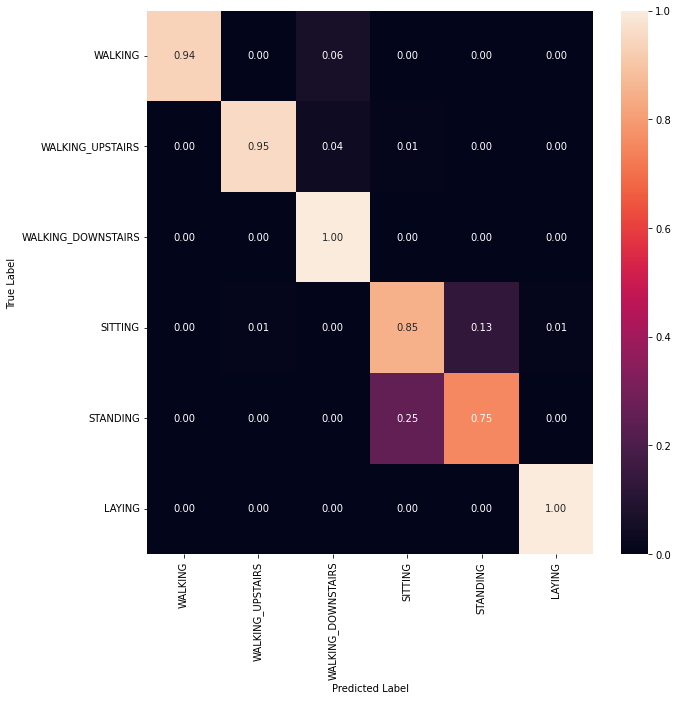

In [58]:
#List out target names
target_names = list(ACTIVITIES.values())

#Use seaborn to plot heat map of confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(normalized_cm, annot=True, fmt='.2f', xticklabels = target_names, yticklabels = target_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show(block=False)

In [59]:
score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 [==============================] - 8s 83ms/step - loss: 0.4703 - accuracy: 0.9118

   cat_crossentropy  ||   accuracy 
  ____________________________________
[0.47033947706222534, 0.9117746949195862]


## Architecture 3: Use 1 LSTM Layer

In [60]:
##Hyperparameters
epochs = 30
batch_size = 16
n_hidden_1 = 32
n_hidden_2 = 16
dropout_p = 0.5

In [61]:
model = Sequential() #Initializing our Model Architecture

# Add an LSTM Layer
model.add(LSTM(n_hidden_1, input_shape = (T, D)))

# Adding a dropout layer
model.add(Dropout(dropout_p))

#Add another Dense Layer
model.add(Dense(n_hidden_2, activation = "relu"))

# Adding a Dense Layer with the Softmax Activation Function
model.add(Dense(n_classes, activation = 'softmax'))

model.summary() #Display a Summary of our model architecture

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 32)                5376      
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 16)                528       
                                                                 
 dense_16 (Dense)            (None, 6)                 102       
                                                                 
Total params: 6006 (23.46 KB)
Trainable params: 6006 (23.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [62]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [63]:
# Training the model
model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test),epochs=epochs)

Epoch 1/30
460/460 [==============================] - 60s 115ms/step - loss: 1.1877 - accuracy: 0.4886 - val_loss: 1.0038 - val_accuracy: 0.6135
Epoch 2/30
460/460 [==============================] - 51s 110ms/step - loss: 0.7921 - accuracy: 0.6710 - val_loss: 0.6707 - val_accuracy: 0.7184
Epoch 3/30
460/460 [==============================] - 45s 98ms/step - loss: 0.6214 - accuracy: 0.7412 - val_loss: 0.8425 - val_accuracy: 0.6834
Epoch 4/30
460/460 [==============================] - 38s 84ms/step - loss: 0.5292 - accuracy: 0.7797 - val_loss: 0.5221 - val_accuracy: 0.7961
Epoch 5/30
460/460 [==============================] - 38s 83ms/step - loss: 0.4567 - accuracy: 0.8120 - val_loss: 0.5158 - val_accuracy: 0.8208
Epoch 6/30
460/460 [==============================] - 42s 92ms/step - loss: 0.3823 - accuracy: 0.8545 - val_loss: 0.5520 - val_accuracy: 0.8181
Epoch 7/30
460/460 [==============================] - 41s 90ms/step - loss: 0.2751 - accuracy: 0.9078 - val_loss: 0.5996 - val_accurac

In [64]:
#Generate Confusion Matrix
Y_test_labels = np.argmax(Y_test, axis=1)
Y_prediction_labels = np.argmax(model.predict(X_test), axis = 1)
normalized_cm = confusion_matrix(Y_test_labels,Y_prediction_labels, normalize = 'true')

93/93 [==============================] - 1s 11ms/step


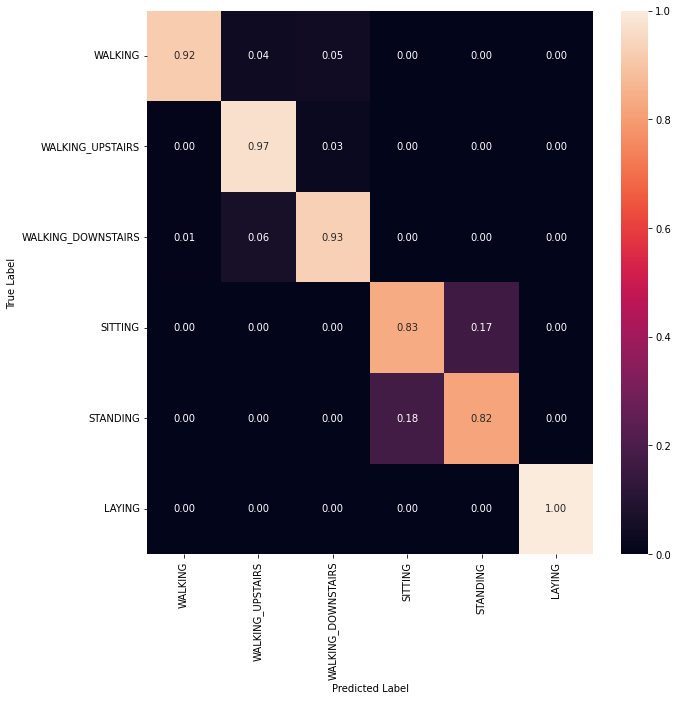

In [65]:
#List out target names
target_names = list(ACTIVITIES.values())

#Use seaborn to plot heat map of confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(normalized_cm, annot=True, fmt='.2f', xticklabels = target_names, yticklabels = target_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show(block=False)

In [66]:
score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 [==============================] - 1s 9ms/step - loss: 0.4163 - accuracy: 0.9101

   cat_crossentropy  ||   accuracy 
  ____________________________________
[0.41629958152770996, 0.9100780487060547]
